C:\Users\poooj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Davies-Bouldin Index: 1.12


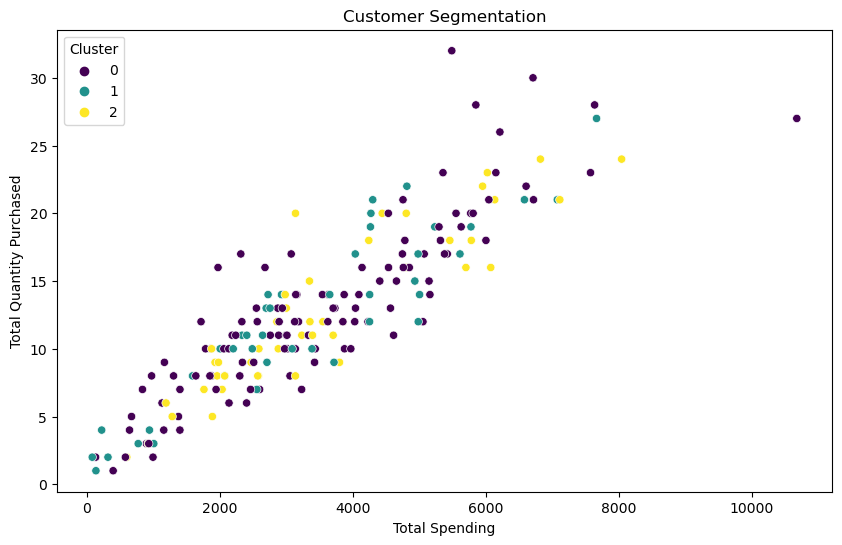

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

merged_df = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

merged_df.fillna({
    'TotalValue': merged_df['TotalValue'].median(),  # Replace NaN with median TotalValue
    'Quantity': merged_df['Quantity'].median(),  # Replace NaN with median Quantity
    'Category': 'Unknown'  # Fill missing categories with 'Unknown'
}, inplace=True)

customer_profiles = merged_df.groupby('CustomerID').agg({
    'TotalValue': 'sum',    # Total spending per customer
    'Quantity': 'sum',      # Total quantity purchased per customer
    'Category': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown'  # Most frequent category
}).reset_index()

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_category = encoder.fit_transform(customer_profiles[['Category']])

encoded_df = pd.DataFrame(encoded_category, columns=encoder.get_feature_names_out(['Category']))
customer_profiles_encoded = pd.concat([customer_profiles.drop(columns=['Category', 'CustomerID']), encoded_df], axis=1)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_profiles_encoded)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_data)

customer_profiles['Cluster'] = clusters

db_index = davies_bouldin_score(scaled_data, clusters)
print(f'Davies-Bouldin Index: {db_index:.2f}')


plt.figure(figsize=(10, 6))
sns.scatterplot(x=customer_profiles['TotalValue'], y=customer_profiles['Quantity'], hue=customer_profiles['Cluster'], palette='viridis')
plt.title('Customer Segmentation')
plt.xlabel('Total Spending')
plt.ylabel('Total Quantity Purchased')
plt.legend(title='Cluster')
plt.show()

customer_profiles.to_csv('FirstName_LastName_Clustering.csv', index=False)
